In [3]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit

## Решение Задачи 2 из Task 2.3

Разностная схема $$( u_{n+1} - 2u_n + u_{n-1} ) / h^2 = g_n,$$ $$u_0 = 0,\ u_N = 0,\ h N = X.$$

Собственные функции $$ \omega_k (x_n) = \sqrt{\frac{2}{ X}} \sin{ \frac{\pi l x_n}{ X } } $$

Решение задачи сводится к нахождению коэффициентов разложения функции $g(x)$ по собственным функциях.

Для этого решается СЛАУ $A\tilde{\bf C} = {\bf f}_g$, где элементы ${\bf f}_g$: $$f_{gi} = \int^1_0{g(x)\omega_i(x)dx}, $$ а элементы матрицы $A$: $$a_{ij} = \int^1_0{\omega_i(x)\omega_j(x)dx}.$$

Расчет интеграла можно провести методом трапеций



In [71]:
@njit
def Lam( k ):

    global h, X

    return -4. / h ** 2 * np.sin( np.pi * k * h / 2. / X ) ** 2

In [72]:
@njit
def Omega( k, x ):

    global X

    return np.sqrt( 2. / X ) * np.sin( np.pi * k * x / X )

In [73]:
@njit
def g( x ):

  return x ** 3

In [74]:
@njit
def MethTr( f ):

  global h

  S = 0.

  for i in np.arange(0, x.size - 1, 1 ):

    S += h / 2. * ( f[ i ] + f[ i + 1 ] )

  return S

In [75]:
@njit
def Matrix( x ):

  global h, X

  global Omega, MethTr

  A = np.zeros( ( x.size-1, x.size-1 ) )

  for i in np.arange( 0, x.size-1, 1 ):

    for j in np.arange( 0, x.size-1, 1 ):

      A[ i ][ j ] = MethTr( Omega( i + 1, x ) * Omega( j + 1, x ) )

  return A

In [76]:
@njit
def F( x ):

  global g, Omega

  f = np.zeros( x.size-1 )

  for i in np.arange( 0, x.size-1, 1 ):

    f[ i ] = MethTr( g( x ) * Omega( i + 1, x ) )

  return f

In [77]:
@njit
def Cg( A, f ):

  return np.linalg.solve( np.linalg.inv( A ), f )

Проверим наше разложение функции $g(x)$

In [98]:
h = 0.001
X = 1.0
x1 = np.arange( 0, X+h, h )
G = np.zeros( x1.size - 1 )
A = Matrix( x1 )
Fg = F( x1 )
C = Cg(A, Fg)

for i in np.arange( 0, x1.size-1, 1 ):

  for j in np.arange( 0, x1.size-1, 1 ):

    G[ i ] += C[ j ] * Omega( j + 1, x1[ i ] )

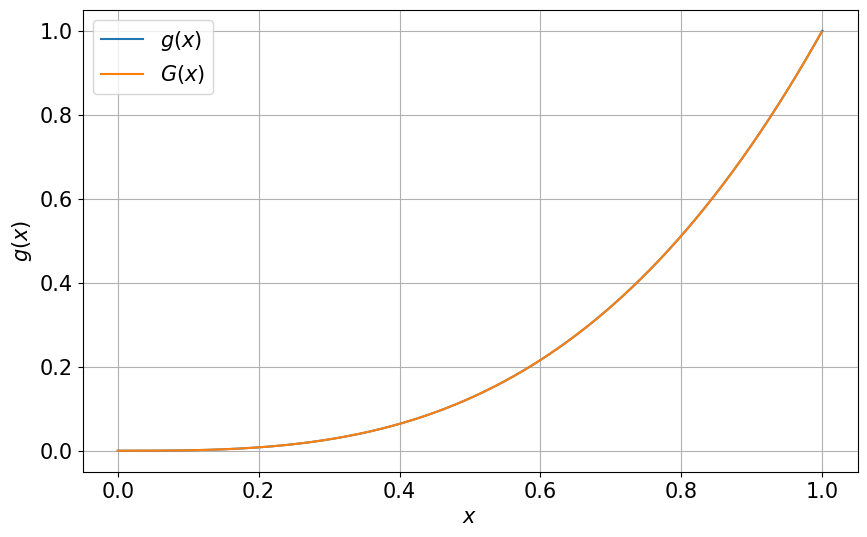

In [99]:
plt.figure( figsize = ( 10, 6 ) )
plt.rc('font', **{'size' : 15})
plt.plot( x1, g(x1), label = r'$g(x)$')
plt.plot(x1[:-1],G, label = r'$G(x)$')
plt.ylabel(r'$g(x)$')
plt.xlabel(r'$x$')
plt.legend()
plt.grid()

Ну а дальше все просто

In [100]:
@njit
def C_coeff( Cg ):

  global Lam

  C = np.zeros( Cg.size-1 )

  for i in np.arange( 0, Cg.size-1, 1 ):

    C[ i ] = Cg[ i ]  / Lam( i + 1 )

  return C

In [101]:
@njit
def U( A, f, x ):

  global C_coeff, Cg, Omega

  C = C_coeff( Cg( A, f ) )

  u = np.zeros( x.size )

  for i in np.arange( 0, x.size-1, 1 ):

    for j in np.arange( 0, x.size-1, 1 ):

      u[ i ] += C[ j ] * Omega( j + 1, x[ i ] )

  return u

Решение ОДУ:

In [102]:
u1 = U( A, Fg, x1 )

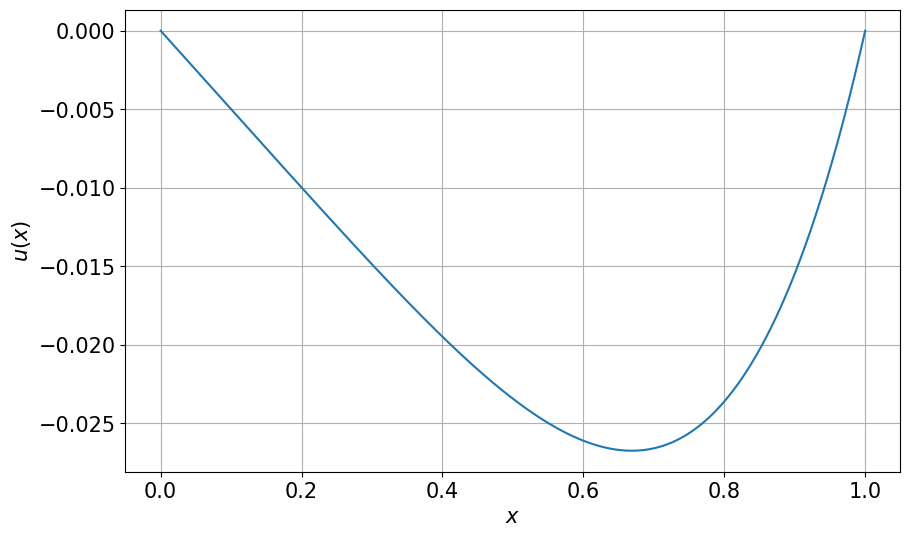

In [103]:
plt.figure( figsize = ( 10, 6 ) )
plt.rc('font', **{'size' : 15})
plt.plot( x1, u1 )
plt.ylabel(r'$u(x)$')
plt.xlabel(r'$x$')
plt.grid()

Проверим полученное решение путем сравнения с решением методом стрельбы
Решается система ОДУ:
$$u' = v$$
$$v' = g(x)$$
$$u(0) = 0$$
$$v(0) = \alpha $$

Пусть ${\bf U} = (u, v)^T$, а ${\bf F} = (v, g(x))^T$ тогда используя явный метод Эйлера $$ {\bf U}_{n+1} = {\bf U}_{n} + h {\bf F}_n $$
Новое значение $\alpha$ будем определять: $$ \alpha_{n+1} = \alpha_{n} - \frac{({\bf U}_{n+1}[N] - {\bf U}(1))h}{{\bf U}_{n+1}[N](\alpha+Δ \alpha) - {\bf U}_{n+1}[N](\alpha)} $$
Это значит, что для определения нового $\alpha$ надо решать задачу 2 раза: c $\alpha$ и $\alpha+Δ \alpha$

In [105]:
@njit
def f(x, y, v):

  global g

  return g( x )

In [106]:
@njit
def MethEl( x, y, v ):

  global h

  v = f( x, y, v ) * h + v

  y = v * h + y

  return v, y

In [107]:
@njit
def Alpha( p, alpha0, y, phi ):

    r = y - phi

    return alpha0 - 1.0 / p * r

In [108]:
def CalYstrel( x, y, Ylast, Scheme):

    global Alpha

    N = x.shape[ 0 ]

    v = np.zeros( N )

    v[ 0 ] = 1.13

    y_st = np.copy( y )
    v_st = np.copy( v )
    v_st[0] = v[0] + 0.005

    while np.fabs( y[ -1 ] - Ylast ) > 1.0e-2:

        for i in np.arange( 0, N - 1, 1 ):

            v[ i + 1 ], y[ i + 1 ] = Scheme( x[ i ], y[ i ], v[ i ] )

            v_st[ i + 1 ], y_st[ i + 1 ] = Scheme( x[ i ], y_st[ i ], v_st[ i ] )

        v[ 0 ] = Alpha( ( y_st[-1] - y[-1] ) / 0.005, v[ 0 ], y[ -1 ], Ylast )

        v_st[0] = v[0] + 0.005

    print( 'Last alpha =', v[ 0 ] )

    return y

In [109]:
h = 1.0e-3

x = np.arange( 0, 1, h )

y = np.copy( x )

y[ 0 ] = 0.

y = CalYstrel( x, y, 0, MethEl )

Last alpha = -0.04980021663333338


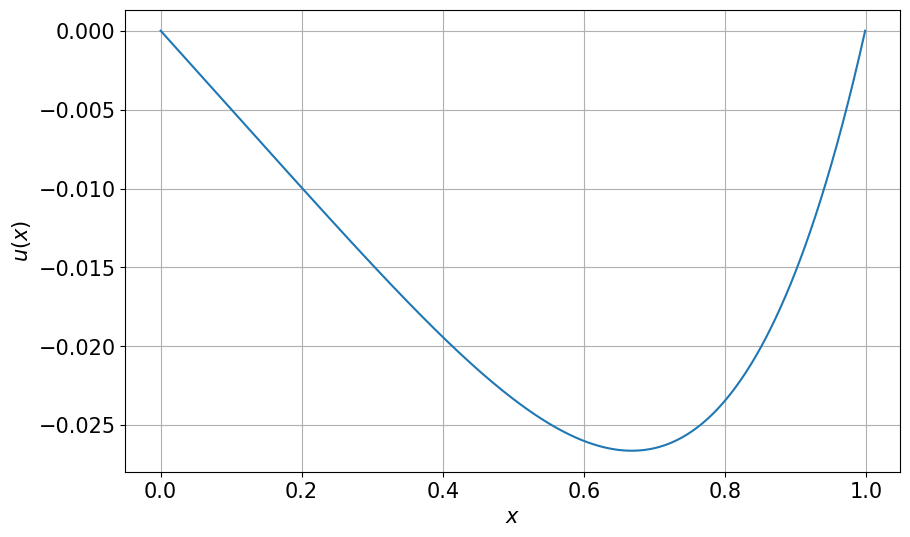

In [110]:
plt.figure( figsize = ( 10, 6 ) )
plt.rc('font', **{'size' : 15})
plt.plot( x, y )
plt.ylabel(r'$u(x)$')
plt.xlabel(r'$x$')
plt.grid()

Сопоставим решения

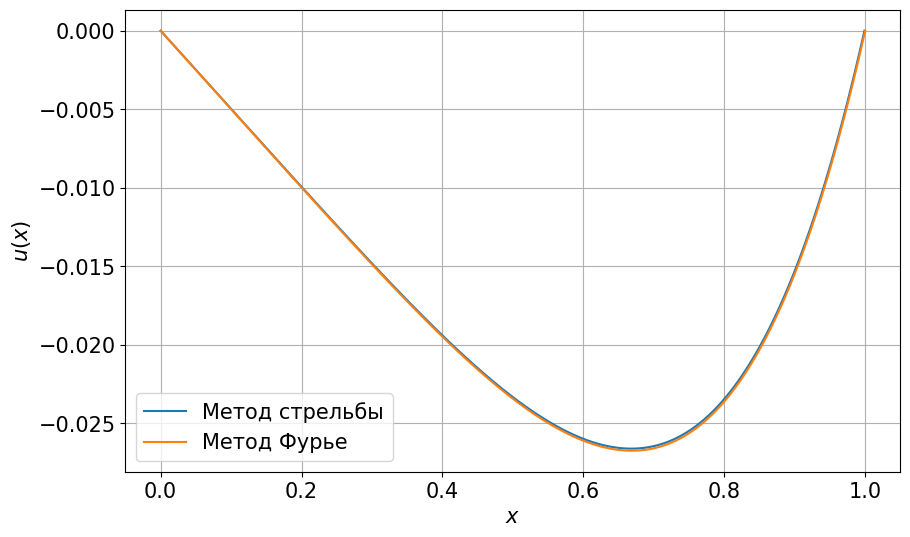

In [111]:
plt.figure( figsize = ( 10, 6 ) )
plt.rc('font', **{'size' : 15})
plt.plot( x, y, label = 'Метод стрельбы' )
plt.plot( x1, u1, label = 'Метод Фурье' )
plt.ylabel(r'$u(x)$')
plt.xlabel(r'$x$')
plt.legend()
plt.grid()